## Import Packages

In [1]:
#importing some useful packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


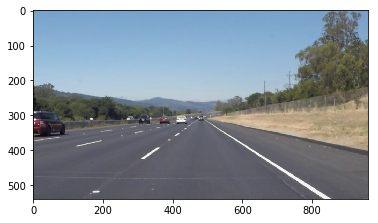

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

# Pipeline

### Helper Functions

In [3]:
filename = 'functions.py'
exec(compile(open(filename, "rb").read(), filename, 'exec'))

In [4]:
memory = []
MEMORY_LENGTH_FRAMES = 8
def process_memory(new_data):
    memory.append(new_data)
    if len(memory) > MEMORY_LENGTH_FRAMES:
        memory.pop(0)

def guess_lines(original_image, return_value = 'default'):
    global memory
    grayscale_img = grayscale(original_image)
    if return_value == 'grayscale':
        return grayscale_img
    blur_gray = gaussian_blur(img=grayscale_img, kernel_size=5)
    if return_value == 'blur_gray':
        return blur_gray
    edges = canny(img=blur_gray, low_threshold=50, high_threshold=150)
    if return_value == 'canny_edges':
        return edges
    imshape = edges.shape
    len_x = imshape[1]
    len_y = imshape[0]
    vertices = np.array([[
        (0,len_y),
        (len_x * 0.45, len_y * 0.62),
        (len_x * 0.55, len_y * 0.62),
        (len_x, len_y)]],
        dtype=np.int32)

    mask = np.zeros_like(edges)   
    ignore_mask_color = 255   
    
    masked_edges = region_of_interest(edges, vertices=vertices)
    if return_value == 'masked_edges':
        return masked_edges
    # Get the hough transform working
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    hough_trans = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    if return_value == 'hough_transform':
        return hough_trans
    try:
        bounds = get_lane_linear_approx_end_points(hough_trans)
        process_memory(bounds)
    except:
        pass
    final_predictions = merge_predictions()
    base_image = np.copy(original_image)
    left = final_predictions['left']
    right = final_predictions['right']
    new_img = cv2.line(original_image, left[0], left[1], color=[0,255,0], thickness=12)
    new_img = cv2.line(original_image, right[0], right[1], color=[0,255,0], thickness=12)
    #final_image = cv2.addWeighted(base_image, 0.6, new_img, 0.4, 0.5)
    return new_img
        
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return guess_lines(image)

def merge_predictions():
    global memory
    coords = [m['left'][0] for m in memory]
    left_start = [int(sum(y) / len(y)) for y in zip(*coords)]
    coords = [m['left'][1] for m in memory]
    left_end = [int(sum(y) / len(y)) for y in zip(*coords)]
    coords = [m['right'][0] for m in memory]
    right_start = [int(sum(y) / len(y)) for y in zip(*coords)]
    coords = [m['right'][1] for m in memory]
    right_end = [int(sum(y) / len(y)) for y in zip(*coords)]
    return{'left':[tuple(left_start), tuple(left_end)],
           'right':[tuple(right_start), tuple(right_end)],
          }

### Step 1: grayscale

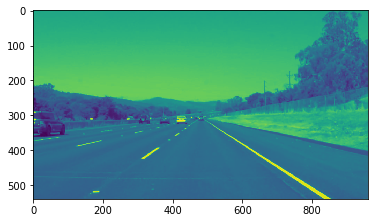

In [5]:
plt.imshow(guess_lines(image, return_value='grayscale'))

### Step 2: gaussian_blur

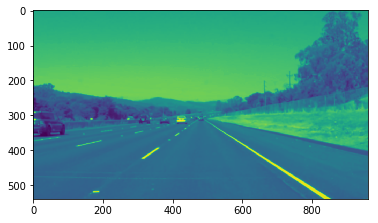

In [6]:
plt.imshow(guess_lines(image, return_value='blur_gray'))

### Step 3: canny edge detection

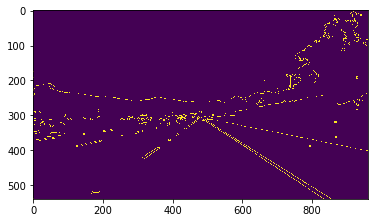

In [7]:
plt.imshow(guess_lines(image, return_value='canny_edges'))

### Step 4: masking

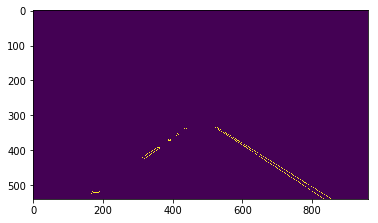

In [8]:
plt.imshow(guess_lines(image, return_value='masked_edges'))

### Step 5: hough transform

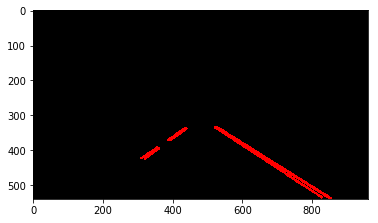

In [9]:
plt.imshow(guess_lines(image, return_value='hough_transform'))

### Step 6: Fit equation


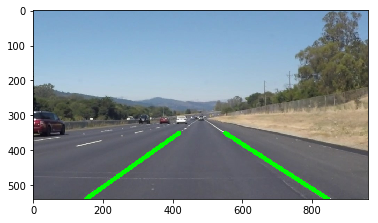

In [10]:
plt.imshow(guess_lines(image, return_value='default'))

# Run pipeline on videos

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Let's try the one with the solid white lane on the right first ...

In [12]:
# Reset memory, used in smoothing
memory = []
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:07<00:00, 23.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.39 s, sys: 1.57 s, total: 7.95 s
Wall time: 8.65 s


#### Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
%pdb on
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Automatic pdb calling has been turned ON
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:24<00:00, 28.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 20.1 s, sys: 5.97 s, total: 26.1 s
Wall time: 25.8 s
